In [13]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import jax.random as jr
import jax.numpy as jnp
import jax
from dynamax.hidden_markov_model import GaussianHMM, DiagonalGaussianHMM, LinearAutoregressiveHMM

import os
import glob
import h5py
import pandas as pd
from functools import reduce
from scipy.signal import butter, filtfilt

from joblib import Parallel, delayed

In [14]:
#utils
def load_fmri(data_root, file_pattern):
    data = []
    subjects = []
    folders = sorted([
        f for f in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, f))
    ])
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(data_root, folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                with h5py.File(file_path, 'r') as hdf:
                    data.append(hdf["dataset"][:])
                    subjects.append(folder)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data, subjects

def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a signal over time
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    x (ndarray): 2D array (time_steps x n_parcels) representing the trajectory of the signal
    dt (float): Time step used in the simulation
    num_trajectories (int): Number of trajectories to randomly select for plotting
    time_steps (int): Total number of time steps in the simulation
    n_parcels (int): Total number of parcels in the simulation
    --------------------------------------------------------------------------------------------------------
    '''
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)

    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)])

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()


def compute_pca(signal, n_components=None):
    '''
    Compute the PCA of a given signal
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    - signal (ndarray): The input signal, shape (n_samples, n_features)
    - n_components (int or None): Number of principal components to keep. If None, all components are kept
    --------------------------------------------------------------------------------------------------------
    Returns:
    - pca_components (ndarray): The principal components of the signal
    - explained_variance_ratio (ndarray): The variance explained by each principal component
    '''
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the signal
    projections = pca.fit_transform(signal)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # eigenvectors
    eigenvectors = pca.components_

    return projections, explained_variance_ratio, eigenvectors


def filter(data, fs, cutoff, filter_type, order):

    filtered_data = []
    for bold in data:
        filtered_bold = butterworth_filter(bold, fs, cutoff, filter_type, order)
        filtered_data.append(filtered_bold)

    return filtered_data

def butterworth_filter(matrix, fs, cutoff, filter_type='high', order=3):
    """
    Applies high-pass or band-pass Butterworth filter to a parcels × time matrix.
    
    Args:
        matrix: 2D array (parcels × time steps)
        fs: Sampling frequency (Hz)
        cutoff: Cutoff frequency/frequencies:
            - Single value for high-pass (e.g., 0.01)
            - Tuple/list for band-pass (e.g., [0.01, high_cutoff])
        filter_type: 'high' or 'band'
        order: Filter order (default=3)
    
    Returns:
        Filtered matrix with same shape as input
    """
    # Input validation
    if filter_type == 'band' and not isinstance(cutoff, (list, tuple)):
        raise ValueError("For band-pass, cutoff must be a list/tuple of [low, high]")
    
    # Design filter
    nyq = 0.5 * fs
    if filter_type == 'high':
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
    elif filter_type == 'band':
        normal_cutoff = [c / nyq for c in cutoff]
        b, a = butter(order, normal_cutoff, btype='band', analog=False)
    
    # Apply zero-phase filtering
    filtered = filtfilt(b, a, matrix, axis=1)  # Axis 1 assumes time is columns
    
    return filtered


def remove_movement(data, subjects, fd):

    good_data = []
    for n, subj in enumerate(subjects):
        subj_idx = fd.index[fd.iloc[:, 0] == subj].to_list()
        if not subj_idx:  # Subject not found case
            print(f"Warning: Subject {subj} not found in FD file. Skipping.")
            continue

        movement = fd.iloc[subj_idx, 1:]
        bold = data[n]
        no_move = np.squeeze(movement < 0.5)
        good_points = bold[:, no_move]
        good_data.append(good_points)

    return good_data


def load_events(data_root, subjects, file_pattern):
    data = []
    subj_folder = ["sub-" + sub.replace("_", "") for sub in subjects]
    folders = [os.path.join(data_root, sub, 'func') for sub in subj_folder]
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                data.append(pd.read_csv(file_path, sep='\t'))
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data

def calculate_volume_pattern(events, tr, n_volumes):

    volume_pattern = np.zeros((len(events), n_volumes))
    for nsubj, event_df in enumerate(events):
        nevents = len(event_df)
        onsets = event_df["onset"].to_numpy()
        onsets = np.floor(onsets / tr)
        durations = event_df["duration"].to_numpy()
        durations = np.floor(durations / tr)
        mapping = {value: index for index, value in enumerate(event_df['trial_type'].unique())}
        trial_types = (event_df['trial_type'].map(mapping)).to_numpy()
        for trial in range(0,nevents):
            onset = int(onsets[trial])
            duration = int(durations[trial])
            trial_type = trial_types[trial]
            volume_pattern[nsubj, onset:(onset+duration)] = trial_type + 1

    return volume_pattern


def get_info(data, column, subjects):
    infos = []
    for subj in subjects:
        subj_idx = data.index[data.iloc[:, 0] == subj].to_list()
        info = data[column].iloc[subj_idx].item()
        infos.append(info)

    return infos




In [15]:
# Load the data
data_root = "/home/zenari/data/fMRI_timeseries_clean_denoised_GSR_parcellated"
file_filter = "task-hammer*.h5"
data, subjects = load_fmri(data_root, file_filter)

No files found matching task-hammer*.h5 in NDAR_INVBL062HTE
No files found matching task-hammer*.h5 in NDAR_INVBY805EE5
No files found matching task-hammer*.h5 in NDAR_INVGB371PPV
No files found matching task-hammer*.h5 in NDAR_INVGT021UPR
No files found matching task-hammer*.h5 in NDAR_INVHA329EL1
No files found matching task-hammer*.h5 in NDAR_INVLL260KC0
No files found matching task-hammer*.h5 in NDAR_INVPF283TAQ
No files found matching task-hammer*.h5 in NDAR_INVRR054KAM
No files found matching task-hammer*.h5 in NDAR_INVUA181LXU
No files found matching task-hammer*.h5 in NDAR_INVVU614ZKP
No files found matching task-hammer*.h5 in NDAR_INVXR625UBQ
No files found matching task-hammer*.h5 in NDAR_INVXV404VJL
No files found matching task-hammer*.h5 in NDAR_INVYT858CBN
No files found matching task-hammer*.h5 in NDAR_INVZH090MNG
No files found matching task-hammer*.h5 in NDAR_INVZU586UPF


In [16]:
print('Number of fMRI:', len(subjects))
print('Shape of example fMRI:', data[0].shape)

Number of fMRI: 226
Shape of example fMRI: (434, 493)


In [17]:
# Filtered list containing only elements with the expected shape
expected_shape = (434, 493)

selected_subjects = np.array( [subject for n, subject in enumerate(subjects) if data[n].shape[1]==expected_shape[1]] )

print('Initial number of fMRI:', len(data))
data_complete_task = [sub for sub in data if sub.shape == expected_shape]
print('Final number of fMRI:', len(data_complete_task))

Initial number of fMRI: 226
Final number of fMRI: 219


In [18]:
TR = 0.8
data_filtered= filter(data_complete_task, fs= 1/TR, cutoff=0.01, filter_type='high', order=2)

#remove movement
fd = pd.read_csv('/home/zenari/data/motion_FD/TCP_FD_hammer_AP.csv', sep=',', header=None)
data_no_mov = remove_movement(data_filtered, selected_subjects, fd)

In [19]:
#Subsampling the data

data_to_consider = data_filtered

n = 219 #number of fMRI
n_sample = np.random.randint(0, len(data_to_consider), n)

data_sub = [data_to_consider[i] for i in range(n)]

data_sub = np.array(data_sub)

data_sub.shape


(219, 434, 493)

In [20]:
### diagnosis
demo = pd.read_csv("/home/zenari/data/demos.tsv", sep=',', skiprows=1, encoding="latin1")
diagnoses = get_info(demo, 'Primary_Dx', selected_subjects)

controls = [1 if d == '999' else 0 for d in diagnoses]

len(controls), len(diagnoses), len(selected_subjects)

(219, 219, 219)

In [21]:
#Zscore the data
data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data_sub
    ])    

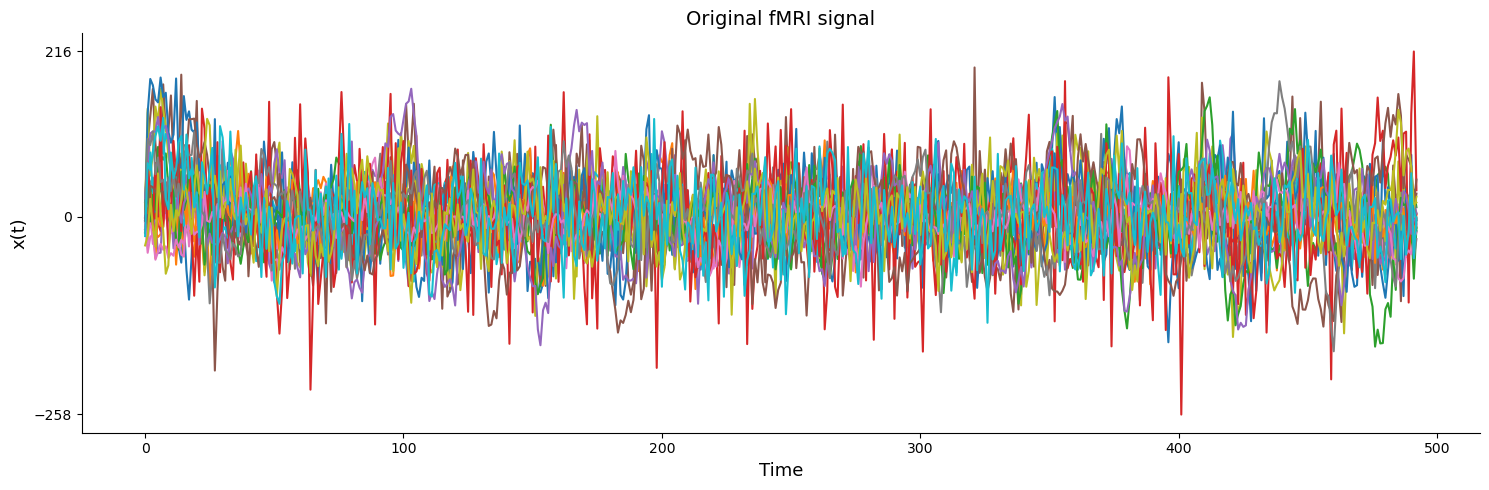

In [22]:
#plotting original sample
k = np.random.randint(0, n)
plot_signals(data_sub[k].T, dt = 1, n_plot=20, n_parcels=data_sub[k].shape[1], title='Original fMRI signal', figsize=(15, 5))

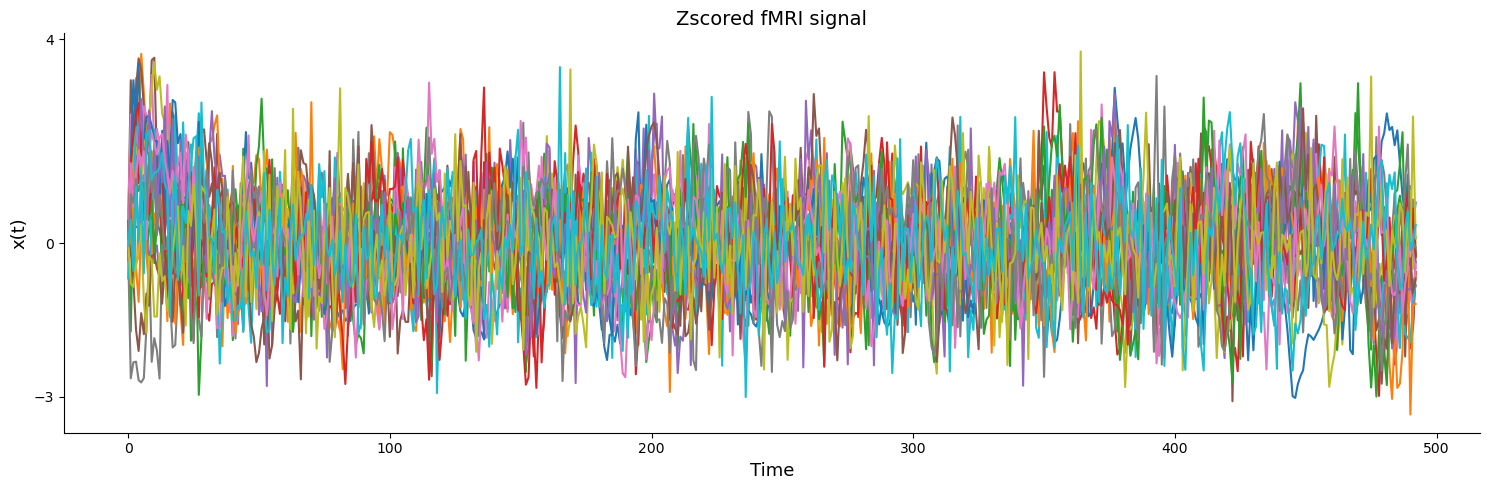

In [23]:
#plotting zscored sample  
plot_signals(data_zsc[k].T, dt = 1, n_plot=20, n_parcels=data_zsc[k].shape[1], title='Zscored fMRI signal', figsize=(15, 5))

In [24]:
print('Shape of the data:', data_zsc.shape)

n_subject = data_zsc.shape[0]
n_parcels = data_zsc.shape[1]
n_time = data_zsc.shape[2]

print('Number of subjects:', n_subject)
print('Number of parcels:', n_parcels)
print('Number of time points:', n_time)

Shape of the data: (219, 434, 493)
Number of subjects: 219
Number of parcels: 434
Number of time points: 493


In [25]:
#loading events
events = load_events('/home/zenari/data/events/', selected_subjects, '*hammer*')

stimuli = calculate_volume_pattern(events, TR, n_time)

In [26]:
### concatenating the data
x = data_zsc.transpose(1, 0, 2).reshape(n_parcels, n_time * n_subject)
print('Shape of the concatenated data:', x.shape)
total_time_points = x.shape[1] 

Shape of the concatenated data: (434, 107967)


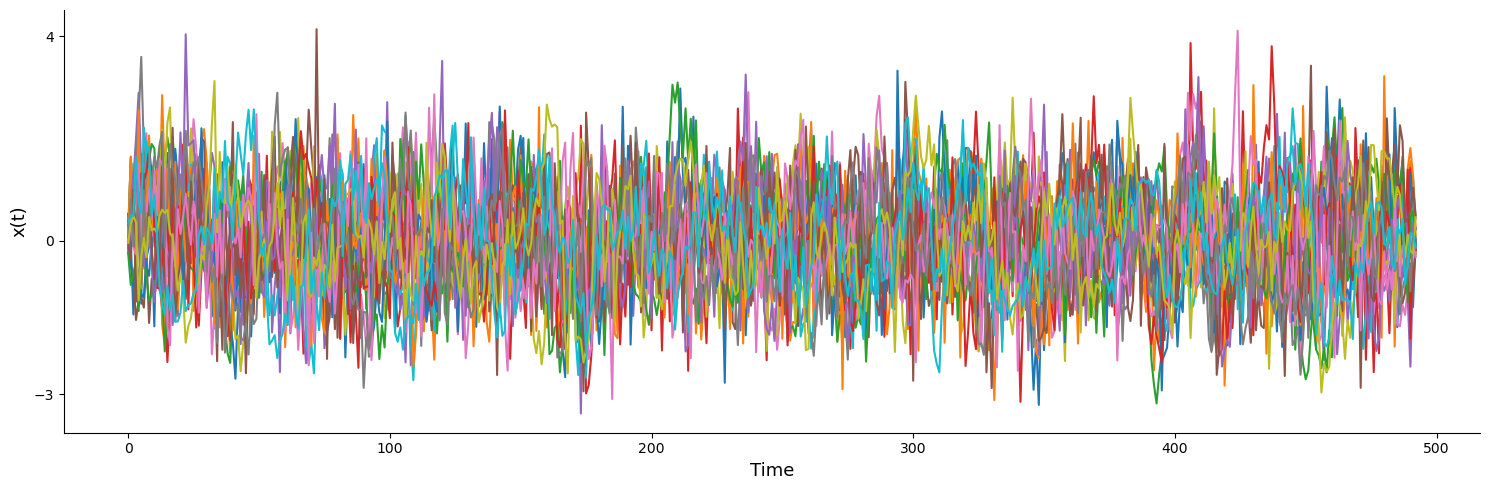

In [27]:
plot_signals(x[:, :n_time].T, dt = 1, n_plot=20, n_parcels=20, figsize=(15, 5))

In [28]:
#checking for Nan
np.isnan(x).any()

False

### PCA

In [29]:
projections, explained_variance_ratio, eigenvectors = compute_pca(x.T, n_parcels)

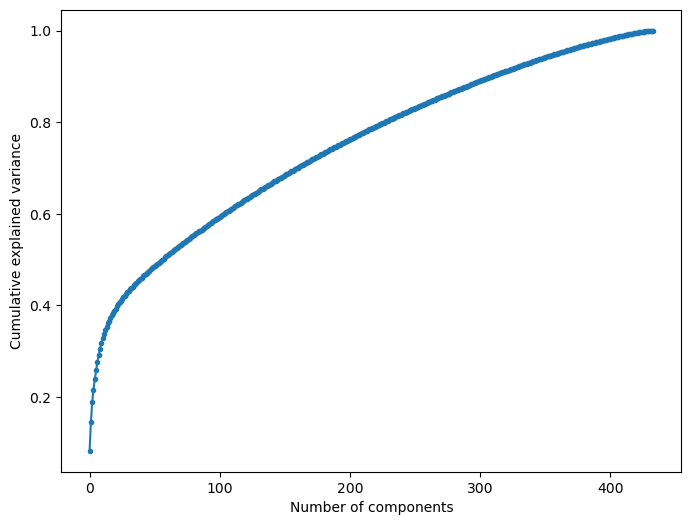

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), '.-')
#plt.plot(np.cumsum(explained_variance_ratio_mean), '.-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
#plt.axvline(20)
#plt.xlim(0, 30)
plt.show()

### Choosing the number of components

Text(0, 0.5, 'Derivative of variance explained')

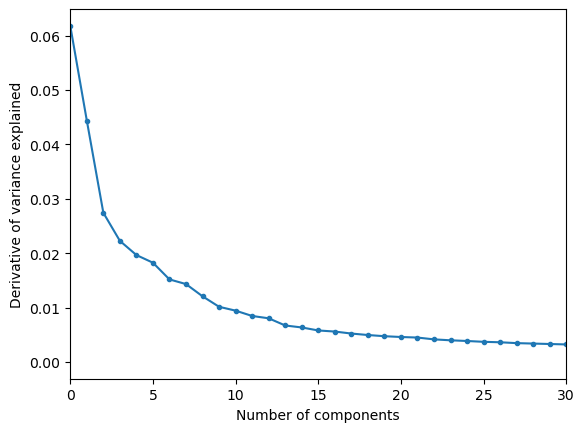

In [31]:
deriv_explained_variance_ratio = np.diff(np.cumsum(explained_variance_ratio))
plt.plot(deriv_explained_variance_ratio, '.-')
plt.xlim(0, 30)
plt.xlabel('Number of components')
plt.ylabel('Derivative of variance explained')

In [32]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1                  # Initial state probs (sum to 1)
    transitions = K * (K - 1)           # Rows of transition matrix sum to 1
    means = K * D                       # One mean vector per state
    covs = K * D * (D + 1) // 2         # One full cov matrix per state
    return init_probs + transitions + means + covs

In [33]:
total_time_points

107967

/tmp/ipykernel_133634/43257246.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


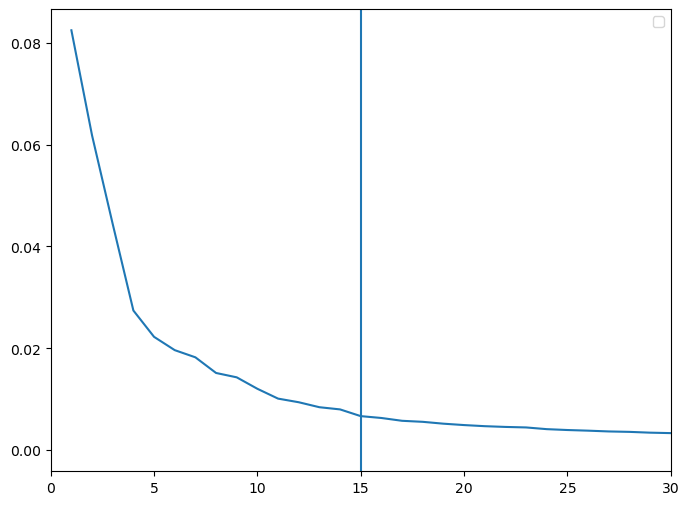

In [41]:
plt.figure(figsize=(8,6))

#plt.plot(np.arange(1, n_parcels+1), np.cumsum(explained_variance_ratio), label = 'expalined variance')
plt.plot(np.arange(1, n_parcels+1) , explained_variance_ratio)

#plt.plot(np.arange(1, n_parcels+1), num_params_gaussian_hmm(5, np.arange(1, n_parcels+1))/num_params_gaussian_hmm(5, 434), label = 'parameters of the model/')

plt.axvline(15)

plt.xlim(0, 30)


plt.legend()

plt.show()


### Plotting timeseries of the first pca

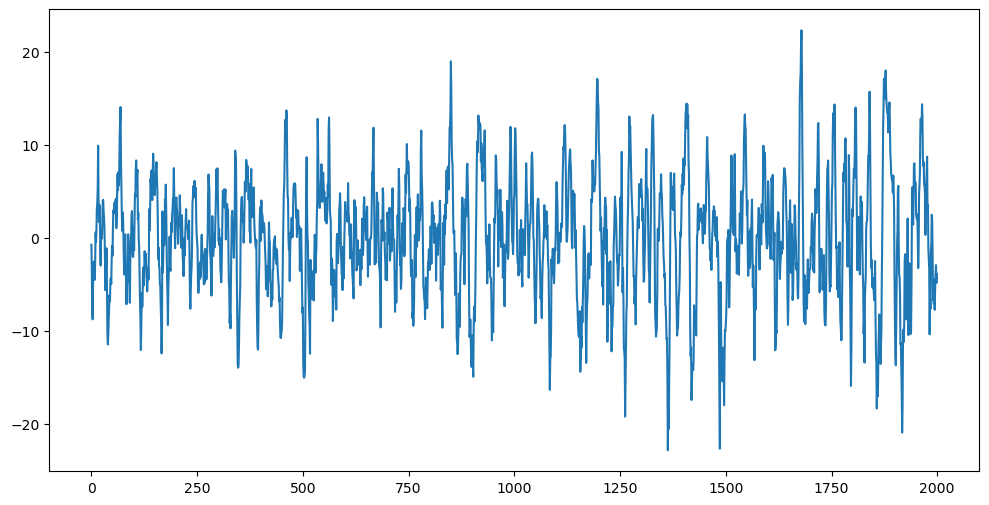

In [42]:
#plotting the time-series of the first pca
plt.figure(figsize=(12, 6))
plt.plot(projections[:2000, 0])
plt.show()

### Number of parameter to estimates

In [43]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1
    transitions = K * (K - 1)
    means = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + means + covs

def num_params_ar_hmm(K, D, P=1):
    init_probs = K - 1
    transitions = K * (K - 1)
    ar_weights = K * D * D * P  # P lags
    biases = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + ar_weights + biases + covs

def num_params_lgssm(D, n):
    # State dynamics
    A = n * n
    Q = (n * (n + 1)) // 2
    # Emission
    C = D * n
    R = (D * (D + 1)) // 2
    # Initial state
    mu0 = n
    Sigma0 = (n * (n + 1)) // 2
    return A + Q + C + R + mu0 + Sigma0

# Example usage:
K = 4   # Number of discrete states
D = 20   # Observation dimension
P = 1   # AR order
n = 3   # Latent state dimension

print("Gaussian HMM params:", num_params_gaussian_hmm(K, D))
print("AR-HMM params:      ", num_params_ar_hmm(K, D, P))
print("LGSSM params:       ", num_params_lgssm(D, n))


Gaussian HMM params: 935
AR-HMM params:       2535
LGSSM params:        294


### HMM parameters

In [216]:
#hyperparameters
n_components = 10
print('Expalined variance considered:', np.cumsum(explained_variance_ratio)[n_components-1])
n_states = 5

Expalined variance considered: 0.31889890051795966


## HMM - Linear Autoregression

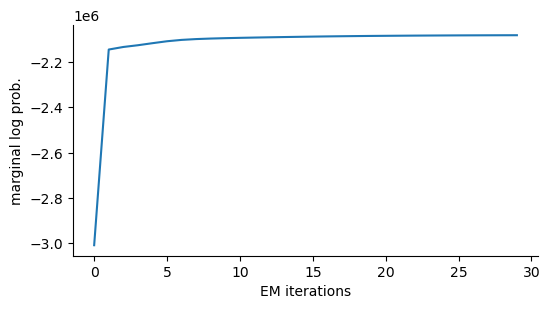

<Figure size 640x480 with 0 Axes>

In [217]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = LinearAutoregressiveHMM(n_states, emissions_dim, num_lags=10)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)

inputs = hmm.compute_inputs(emissions)

#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=30, inputs = inputs)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions, inputs= inputs)

plt.tight_layout()

Subject: 3
Control: 0


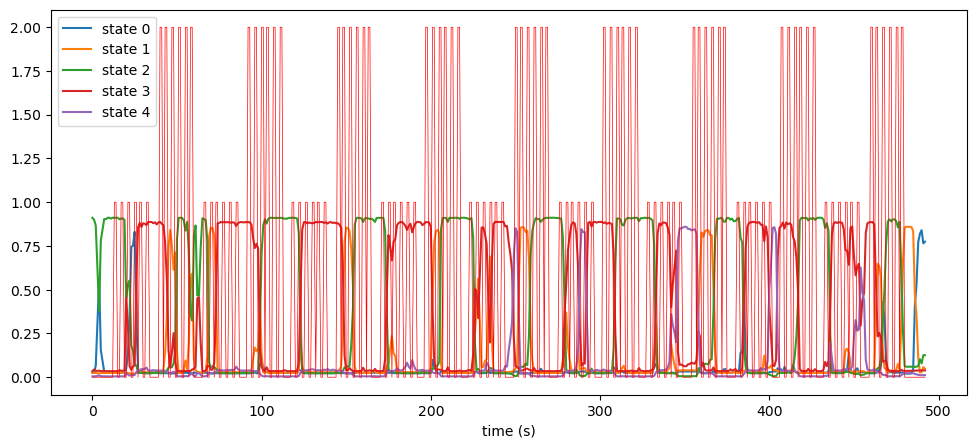

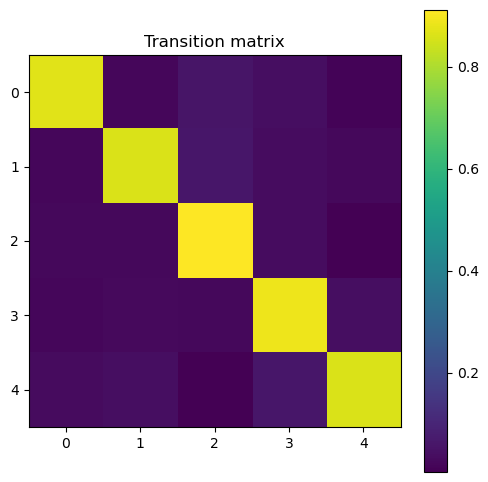

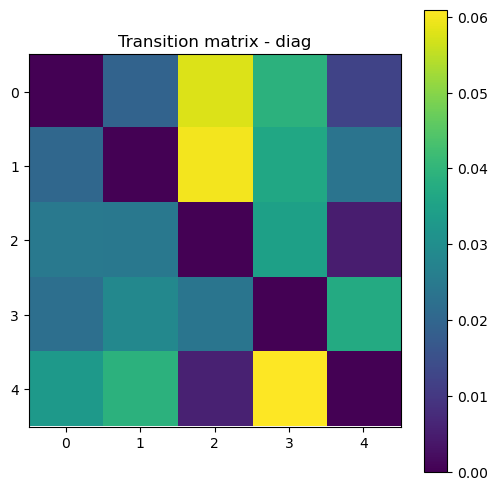

Text(0.5, 0, 'time')

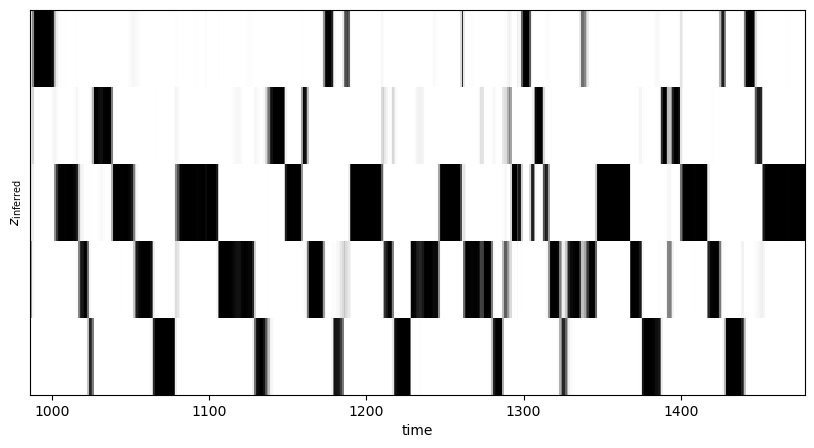

In [262]:
subj = 3

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


### Gaussian HMM

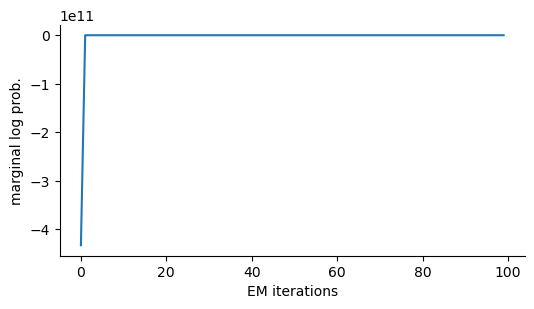

<Figure size 640x480 with 0 Axes>

In [274]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = GaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=100)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

Subject: 3
Control: 0


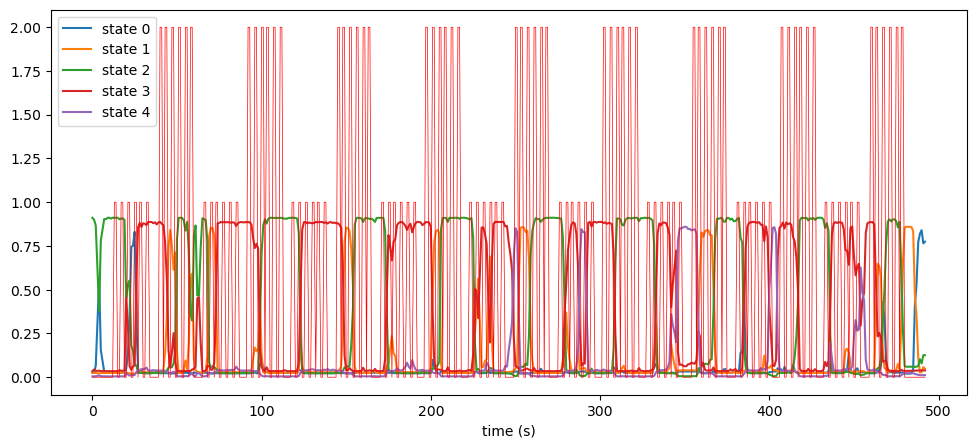

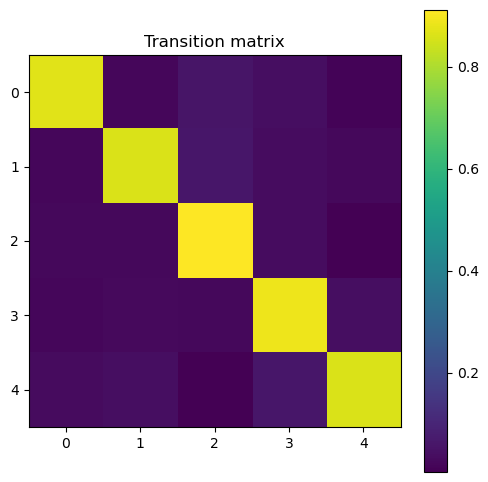

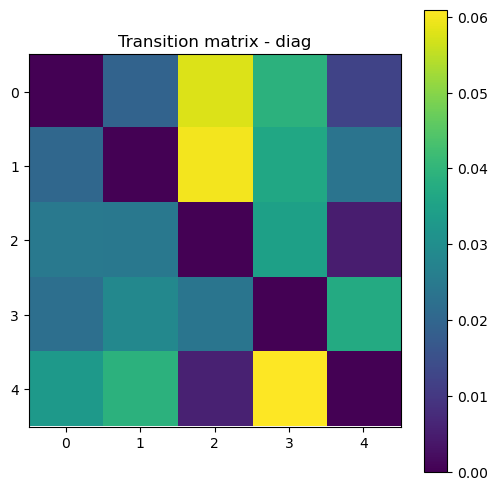

Text(0.5, 0, 'time')

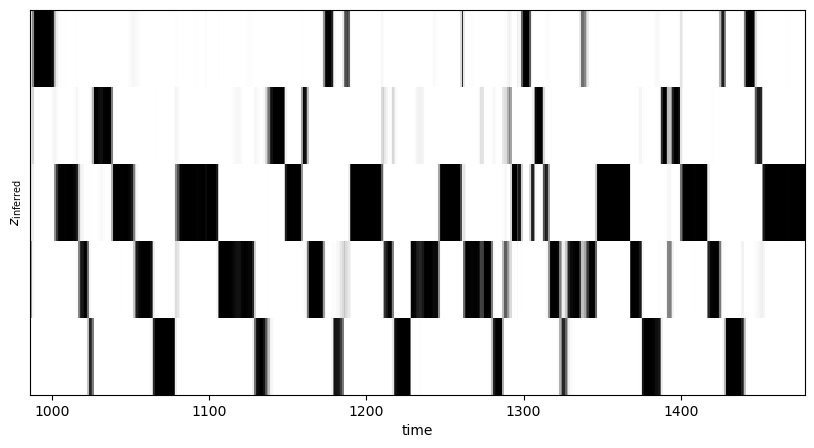

In [275]:
subj = 3

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
row_sums = params_trans.sum(axis=1, keepdims=True)
params_trans = np.divide(params_trans, row_sums, where=row_sums != 0)

plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


### HMM - DiagonalGaussian

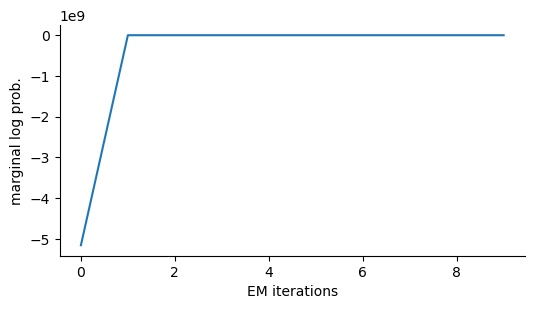

<Figure size 640x480 with 0 Axes>

In [276]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]

hmm = DiagonalGaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=10)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

Subject: 45
Control: 1


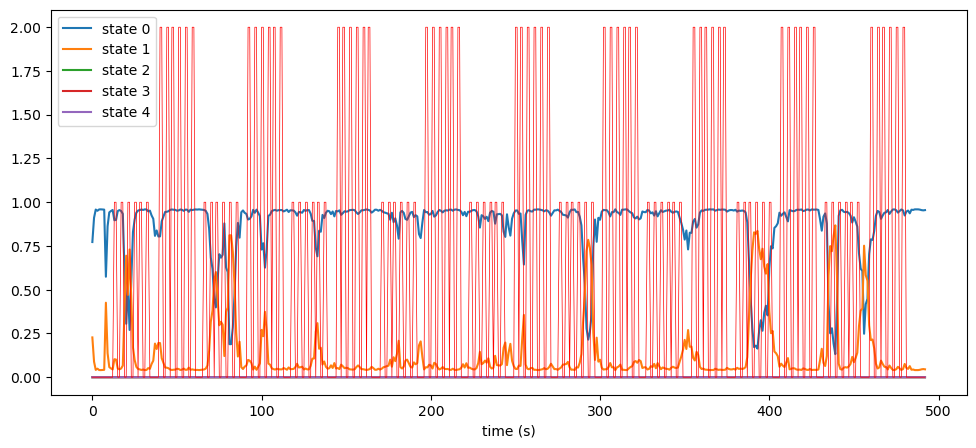

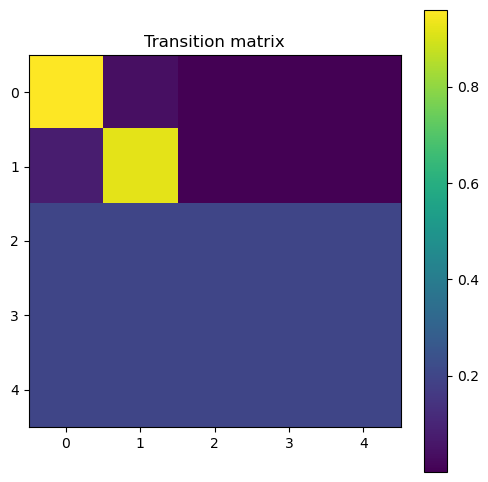

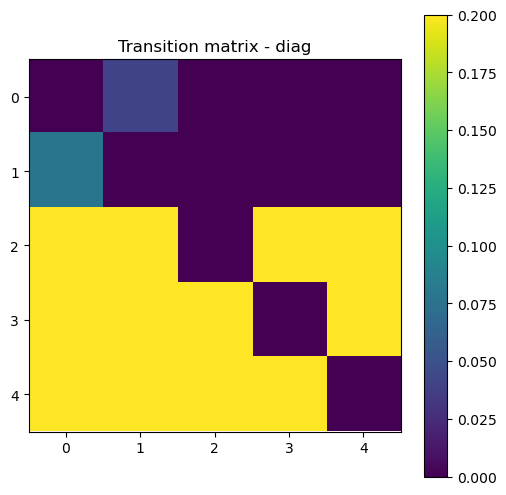

Text(0.5, 0, 'time')

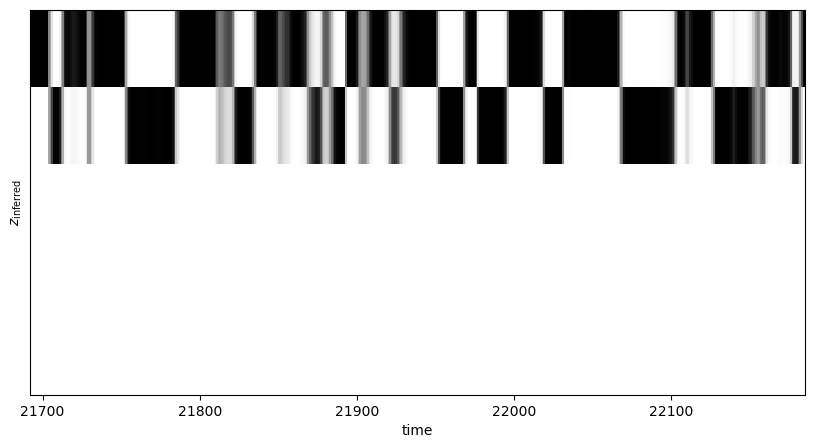

In [278]:
subj = 45

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


## Model selection

In [44]:
n_components_list = [15]

n_states_list = np.arange(2, 15)

n_iter = 100

for n_components in n_components_list:
    print(f"Number of components: {n_components}")
    print(f"Explained variance: {np.cumsum(explained_variance_ratio)[n_components-1]}")

Number of components: 15
Explained variance: 0.3605096102609166


In [45]:
def training(n_components, n_states, projections, n_iter=10):
    
    emissions = projections[:, :n_components]
    emissions_dim = emissions.shape[1]


    hmm = GaussianHMM(n_states, emissions_dim)

    ### Fit it with EM
    params, props = hmm.initialize(emissions=emissions)


    #params, props = hmm.initialize(emissions=emissions)
    params, lls = hmm.fit_em(params, props, emissions, num_iters=n_iter)

    return [n_components, n_states, params, lls]

In [46]:
print('Number of models:', len(n_components_list) * len(n_states_list))
results = Parallel(n_jobs=-1, verbose = 11)(delayed(training)(n_components, n_states, projections, n_iter=n_iter) for n_components in n_components_list for n_states in n_states_list)

Number of models: 13


/home/zenari/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.2s


[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:   50.6s remaining:  4.6min


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:   55.4s remaining:  2.1min


[Parallel(n_jobs=-1)]: Done   6 out of  13 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:  1.1min remaining:   42.9s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:  1.2min remaining:   21.8s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  1.3min finished


In [47]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1                  # Initial state probs (sum to 1)
    transitions = K * (K - 1)           # Rows of transition matrix sum to 1
    means = K * D                       # One mean vector per state
    covs = K * D * (D + 1) // 2         # One full cov matrix per state
    return init_probs + transitions + means + covs


In [48]:
heatmap_data = []
for line in results:
    n_states, n_components, params, lls = line
     # Compute BIC
    num_params = num_params_gaussian_hmm(n_states, n_components)
    bic = -2 * lls[-1].item()/n_states + np.log(total_time_points) * num_params
    heatmap_data.append([n_states, n_components, bic])

heatmap_data = np.array(heatmap_data)
heatmap = heatmap_data[:, 2].reshape(len(n_components_list), len(n_states_list))

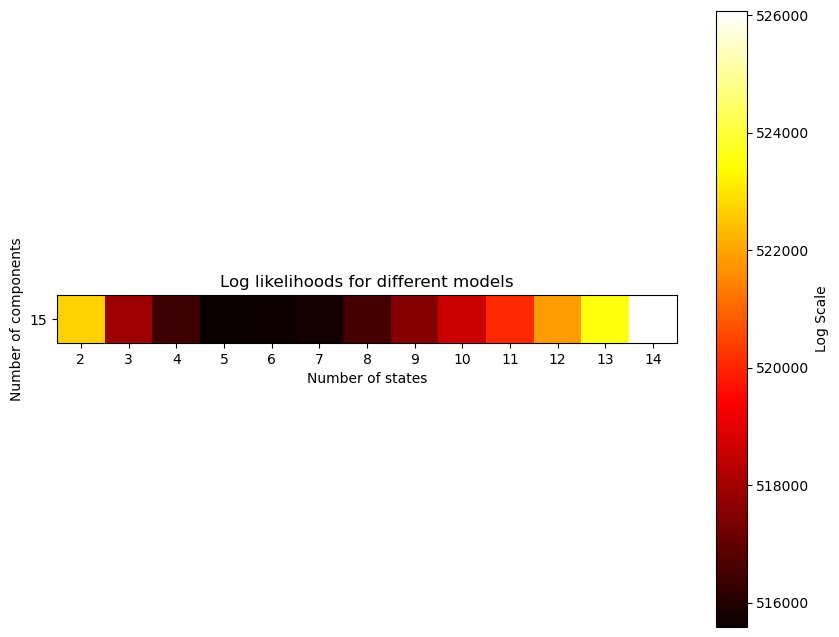

In [49]:
plt.figure(figsize=(10, 8))
img = plt.imshow(heatmap, cmap='hot')
plt.colorbar(img, label='Log Scale')
plt.xticks(np.arange(len(n_states_list)), n_states_list)
plt.yticks(np.arange(len(n_components_list)), n_components_list)
plt.xlabel('Number of states')
plt.ylabel('Number of components')
plt.title('Log likelihoods for different models')
plt.show()

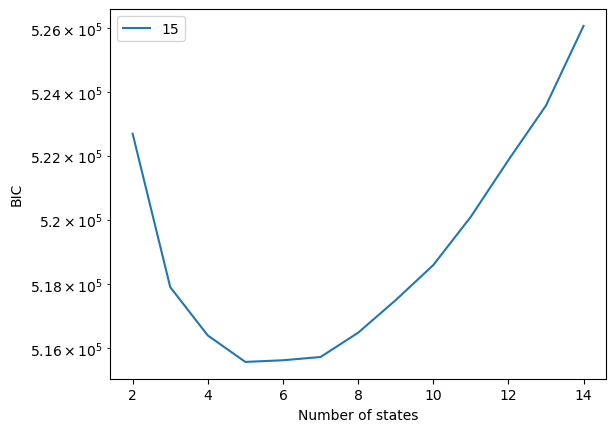

In [50]:
for chosen_n_comp in range(len(n_components_list)):
    plt.plot(n_states_list, heatmap[chosen_n_comp, :], label=n_components_list[chosen_n_comp])
    plt.xlabel('Number of states')
    plt.ylabel('BIC')
plt.legend()
plt.yscale('log')

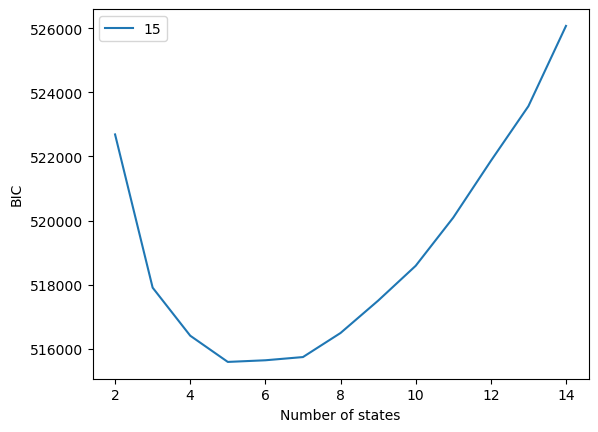

In [51]:
chosen_n_comp = 0
plt.plot(n_states_list, heatmap[chosen_n_comp, :], label=n_components_list[chosen_n_comp])
plt.xlabel('Number of states')
plt.ylabel('BIC')
plt.legend()

### Final model

In [52]:
n_components = 15
n_states = 5

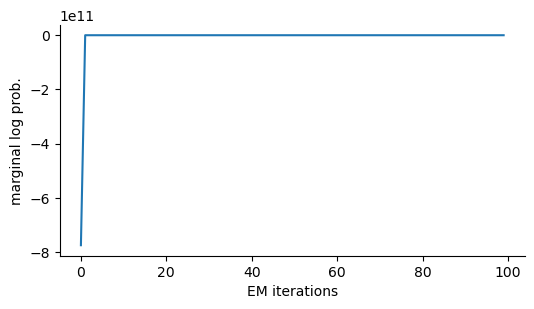

<Figure size 640x480 with 0 Axes>

In [53]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = GaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=100)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

Subject: 29
Control: 1


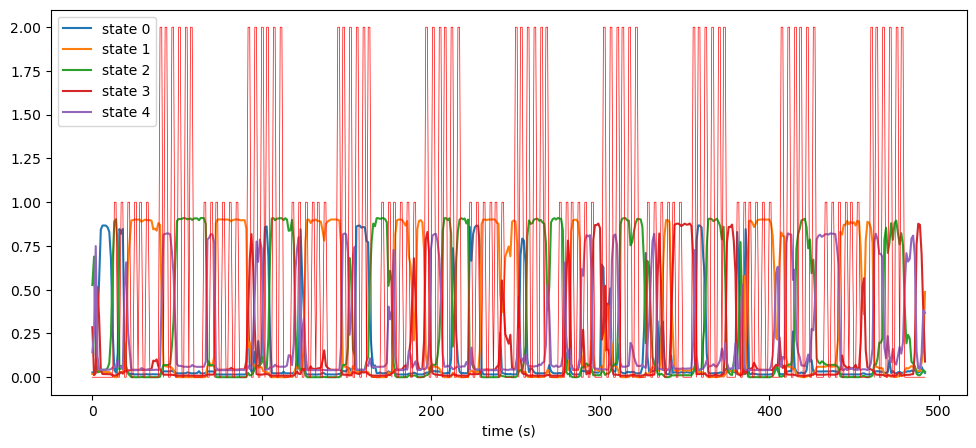

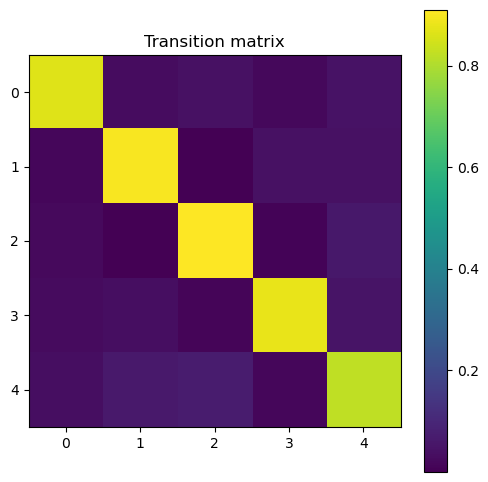

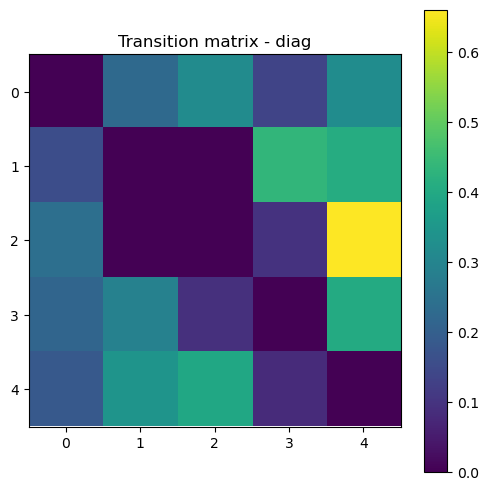

Text(0.5, 0, 'time')

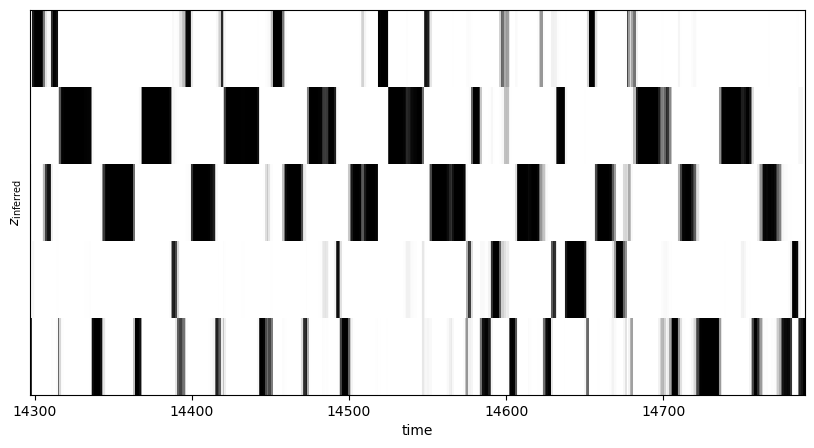

In [123]:
subj = 29

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()

params_trans = np.array(params.transitions).squeeze()
params_trans = params_trans - np.diag(np.diag(params_trans))
row_sums = params_trans.sum(axis=1, keepdims=True)
params_trans = np.divide(params_trans, row_sums, where=row_sums != 0)

plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans)
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj),n_time*(subj+1))
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


### Statistics of states

In [ ]:
post_probs = post.predicted_probs

print(post_probs.shape)

occupied_state = np.argmax(post_probs, axis = 1)
occupied_state.shape

In [89]:
hc = []
pat = []
for n in range(n_subject):
    if controls[n] == 1:
        hc.append(occupied_state[n*n_time:(n+1)*n_time])
    else:
        pat.append(occupied_state[n*n_time:(n+1)*n_time])

hc = np.array(hc)
pat = np.array(pat)

print('Shape of healthy controls:', hc.shape)
print('Shape of patients:', pat.shape)

hc_concat = hc.flatten()
pat_concat = pat.flatten()

print('Shape of healthy controls:', hc_concat.shape)
print('Shape of patients:', pat_concat.shape)

Shape of healthy controls: (90, 493)
Shape of patients: (129, 493)
Shape of healthy controls: (44370,)
Shape of patients: (63597,)


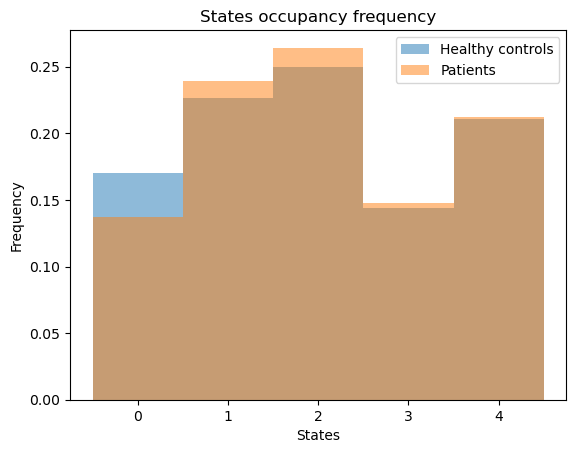

In [97]:
plt.hist(hc_concat, bins = np.arange(0, n_states+1), alpha=0.5, density = True, label='Healthy controls')
plt.hist(pat_concat, bins = np.arange(0, n_states+1), alpha=0.5, density = True, label='Patients')

plt.xlabel('States')
plt.ylabel('Frequency')

plt.xticks(np.arange(0, n_states)+0.5, np.arange(0, n_states))

plt.legend()
plt.title('States occupancy frequency')

plt.show()

In [103]:
dwell_time_hc = [[], [], [], [], []]
counter = 0
for t in range(hc_concat.shape[0]-1):
    if hc_concat[t] == hc_concat[t+1]:
        counter += 1
    else:
        dwell_time_hc[int(hc_concat[t])].append(counter)
        counter = 0

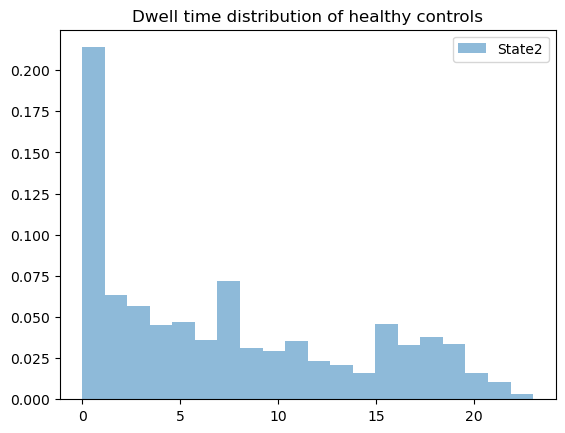

In [114]:
for k in range(n_states):
    plt.hist(dwell_time_hc[k], bins = 20, alpha=0.5, density = True, label='State'+str(k))

plt.legend()
plt.title('Dwell time distribution of healthy controls')
plt.show()

In [110]:
dwell_time_pat = [[], [], [], [], []]
counter = 0
for t in range(pat_concat.shape[0]-1):
    if pat_concat[t] == pat_concat[t+1]:
        counter += 1
    else:
        dwell_time_pat[int(pat_concat[t])].append(counter)
        counter = 0

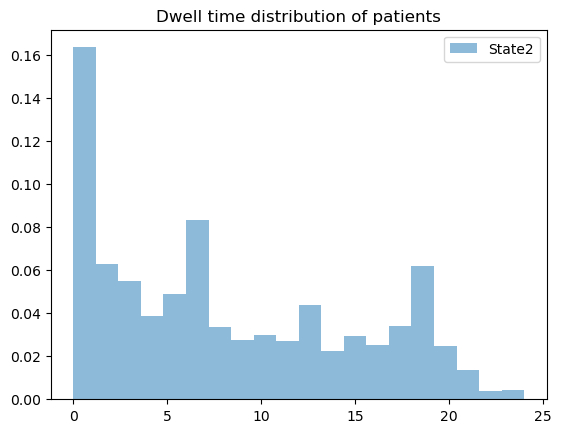

In [112]:
for k in range(n_states):
    plt.hist(dwell_time_pat[k], bins = 20, alpha=0.5, density = True, label='State'+str(k))
plt.legend()
plt.title('Dwell time distribution of patients')
plt.show()

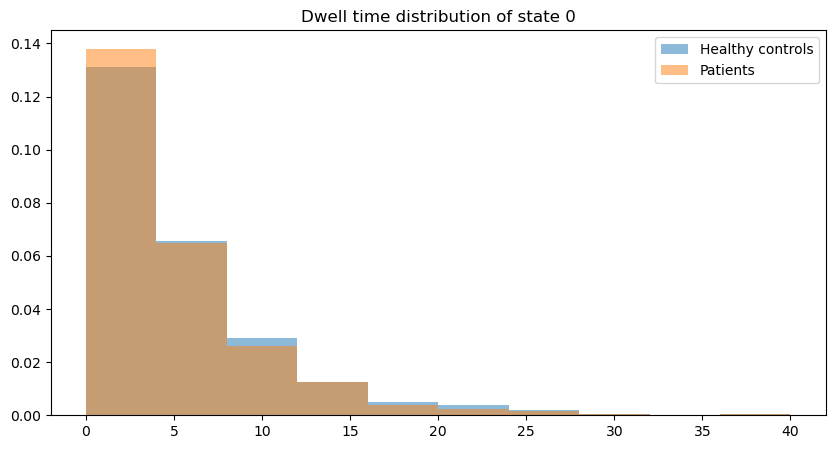

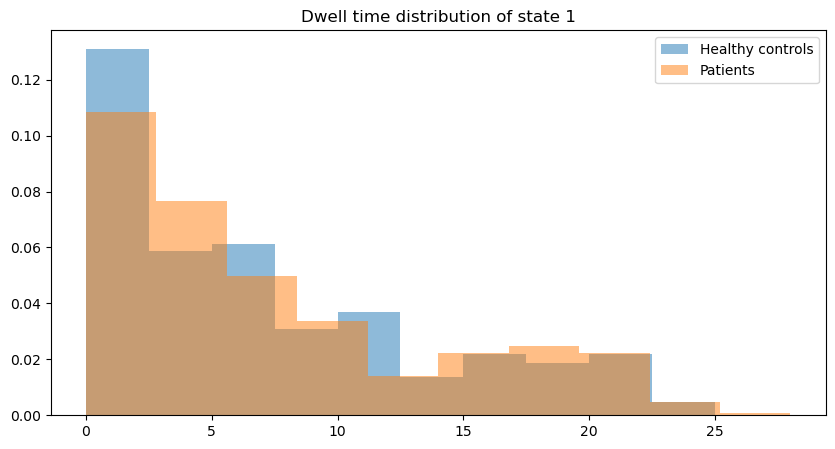

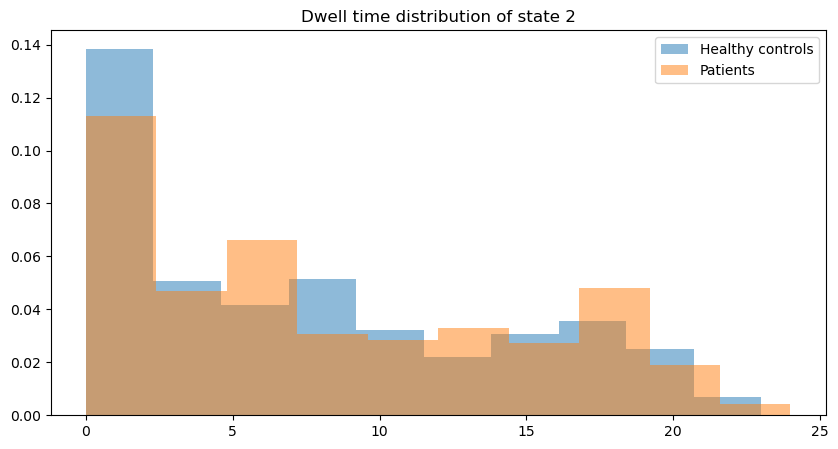

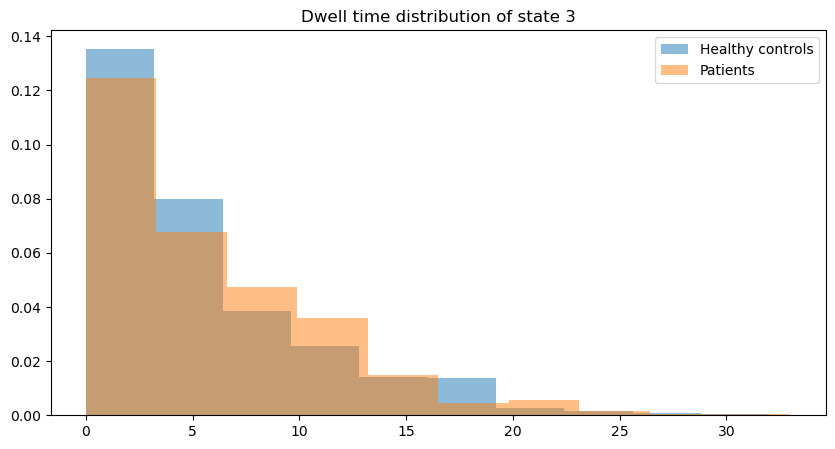

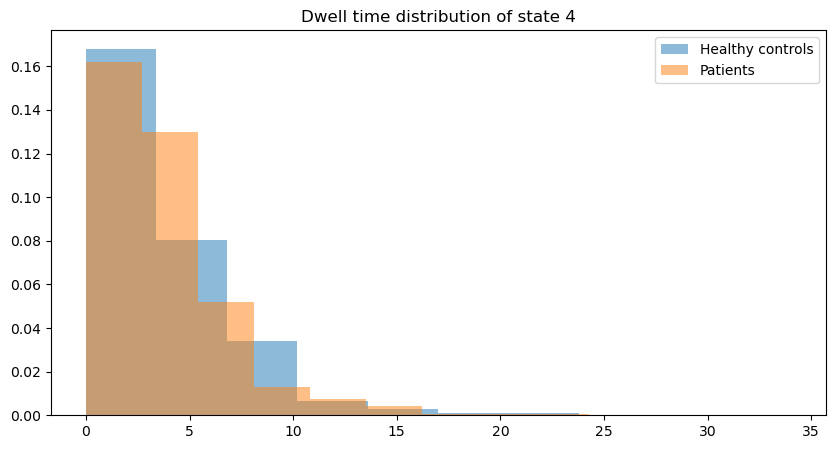

In [118]:
for k in range(n_states):
    plt.figure(figsize=(10, 5))
    plt.hist(dwell_time_hc[k], bins = 10, alpha=0.5, density = True, label='Healthy controls')
    plt.hist(dwell_time_pat[k], bins = 10, alpha=0.5, density = True, label='Patients')
    plt.legend()
    plt.title('Dwell time distribution of state '+str(k))
    plt.show()

In [121]:
from scipy.stats import ttest_ind, mannwhitneyu

for k in range(n_states):
    dwell_time_hc[k] = np.array(dwell_time_hc[k])
    dwell_time_pat[k] = np.array(dwell_time_pat[k])

    # Perform t-test
    array1 = np.array(dwell_time_hc[k])
    array2 = np.array(dwell_time_pat[k])

    mean_hc = np.mean(array1)
    mean_pat = np.mean(array2)

    # Perform t-test
    t_stat, p_value = mannwhitneyu(array1, array2)

    print(f"State {k}:")
    print(f"Mean dwell time (Healthy Controls): {mean_hc}")
    print(f"Mean dwell time (Patients): {mean_pat}")
    print(f"State {k}: t-statistic = {t_stat}, p-value = {p_value}")

State 0:
Mean dwell time (Healthy Controls): 4.7501904036557505
Mean dwell time (Patients): 4.381717109326745
State 0: t-statistic = 1103608.0, p-value = 0.07202167475889207
State 1:
Mean dwell time (Healthy Controls): 7.0223820943245405
Mean dwell time (Patients): 7.326396495071194
State 1: t-statistic = 1115081.0, p-value = 0.2619313771365249
State 2:
Mean dwell time (Healthy Controls): 7.455309396485867
Mean dwell time (Patients): 8.160217983651226
State 2: t-statistic = 1120701.0, p-value = 0.0013360801738521715
State 3:
Mean dwell time (Healthy Controls): 5.485249237029501
Mean dwell time (Patients): 5.8226744186046515
State 3: t-statistic = 645444.5, p-value = 0.057621055515075126
State 4:
Mean dwell time (Healthy Controls): 3.6100691016781834
Mean dwell time (Patients): 3.5791440217391304
State 4: t-statistic = 2956606.5, p-value = 0.6029114463159044


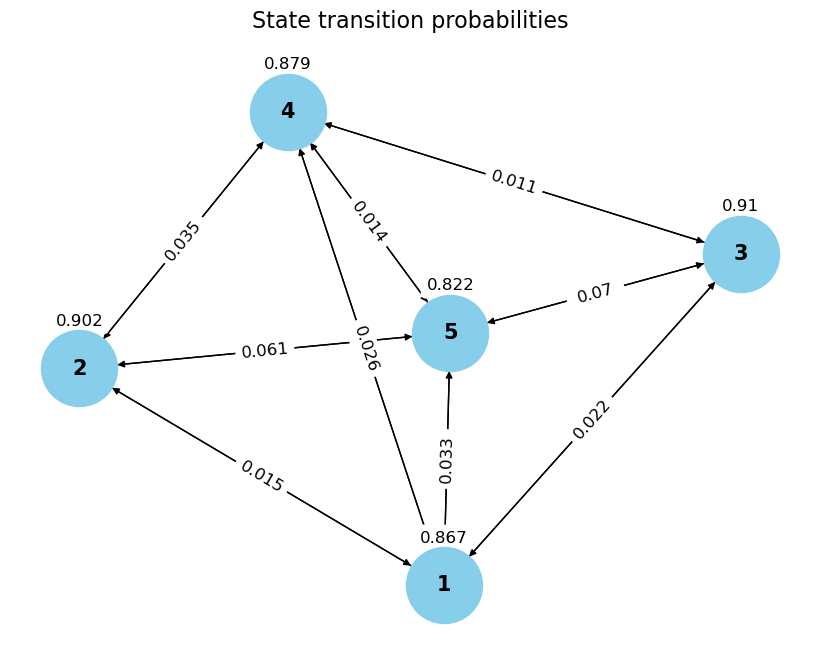

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the transition matrix
P = np.array(params.transitions).squeeze()
P = np.round(P, 3)

# Define the states (optional)
states = ['1', '2', '3', '4', '5']

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for state in states:
    G.add_node(state)

# Add edges based on the transition matrix
for i, state_from in enumerate(states):
    for j, state_to in enumerate(states):
        if P[i][j] > 0:
            G.add_edge(state_from, state_to, weight=P[i][j])

# Draw the graph with labels for the edges (probabilities)
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
plt.title("State transition probabilities", fontsize=16)
plt.show()


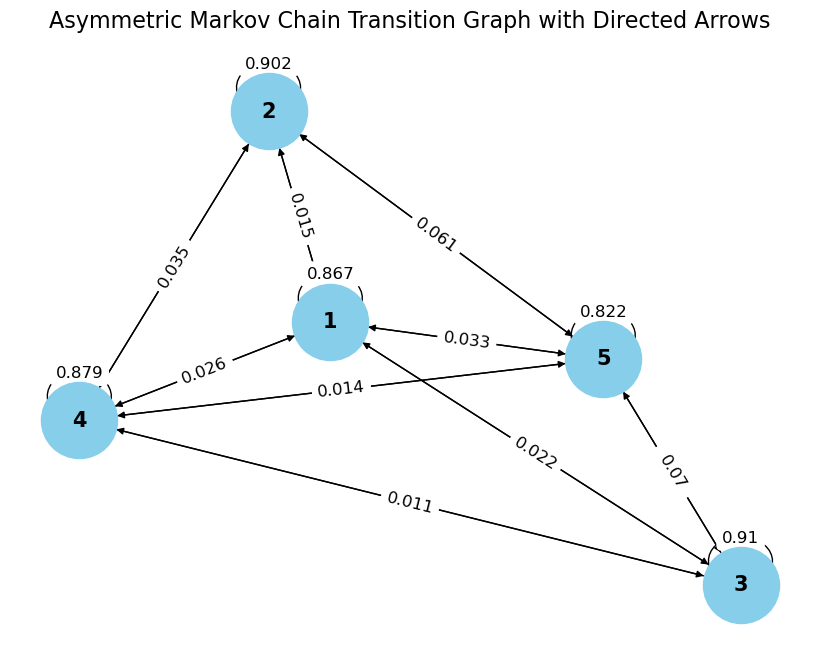

In [69]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the transition matrix
P = np.array(params.transitions).squeeze()
P_asymmetric = np.round(P, 3)

# Define the states (optional)
states = ['1', '2', '3', '4', '5']
# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for state in states:
    G.add_node(state)

# Add edges based on the transition matrix
for i, state_from in enumerate(states):
    for j, state_to in enumerate(states):
        if P_asymmetric[i][j] > 0:  # Only add an edge if the transition probability is non-zero
            G.add_edge(state_from, state_to, weight=P_asymmetric[i][j])

# Draw the graph with directed edges and labels for the edges (probabilities)
pos = nx.spring_layout(G)  # Position the nodes in a layout
plt.figure(figsize=(8, 6))

# Draw the graph with directed arrows
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=15, font_weight='bold', arrows=True)

# Add edge labels (transition probabilities)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Title of the plot
plt.title("Asymmetric Markov Chain Transition Graph with Directed Arrows", fontsize=16)
plt.show()



## Interpreting the states

In [126]:
means = params.emissions.means
covs = params.emissions.covs

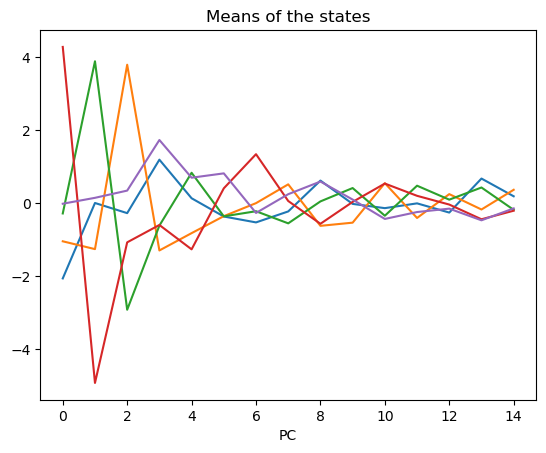

In [132]:
plt.plot(means.T)
plt.title('Means of the states')
plt.xlabel('PC')
plt.show()

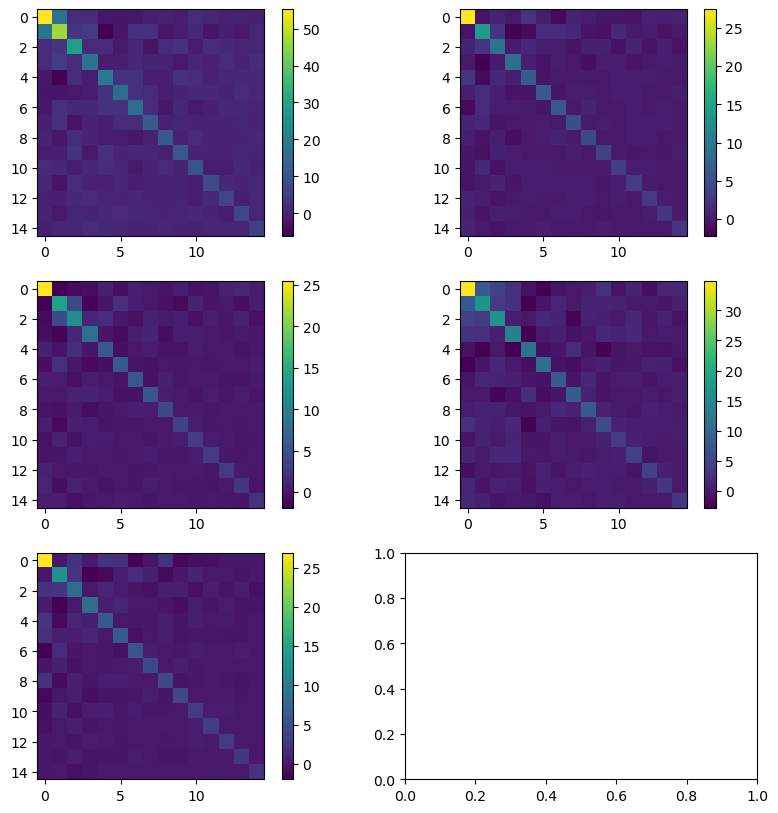

In [130]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
im1 = ax[0, 0].imshow(covs[0])
ax[0, 0].figure.colorbar(im1, ax=ax[0, 0])
im2 = ax[0, 1].imshow(covs[1])
ax[0, 1].figure.colorbar(im2, ax=ax[0, 1])
im3 = ax[1, 0].imshow(covs[2])
ax[1, 0].figure.colorbar(im3, ax=ax[1, 0])
im4 = ax[1, 1].imshow(covs[3])
ax[1, 1].figure.colorbar(im4, ax=ax[1, 1])
im5 = ax[2, 0].imshow(covs[4])
ax[2, 0].figure.colorbar(im5, ax=ax[2, 0])


### Mean bold

In [170]:
U =eigenvectors[:n_components, :]
U.shape

(15, 434)

In [187]:
means_original = []
for k in range(n_states):
    means_original.append(np.dot(U.T, means[k]))

means_original = np.array(means_original)
means_original.shape

(5, 434)

Text(0, 0.5, 'States')

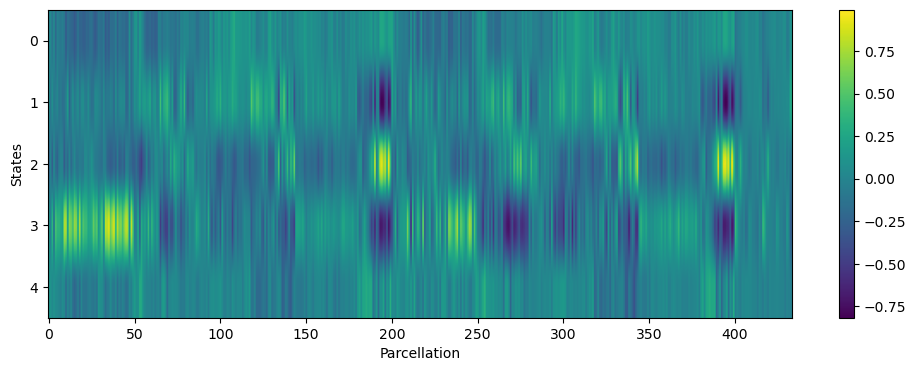

In [197]:
plt.figure(figsize=(12, 4))
plt.imshow(means_original, aspect = 'auto')
plt.colorbar()
plt.xlabel('Parcellation')
plt.ylabel('States')

### Covariances

In [201]:
orignal_cov = []
for k in range(n_states):
    cov = U.T@covs[k]@U
    orignal_cov.append(cov/(np.sqrt(np.outer(np.diag(cov), np.diag(cov)))))

FC = np.array(orignal_cov)
FC.shape

(5, 434, 434)

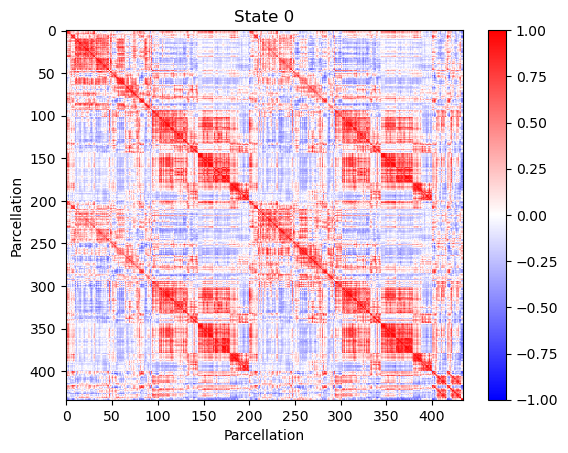

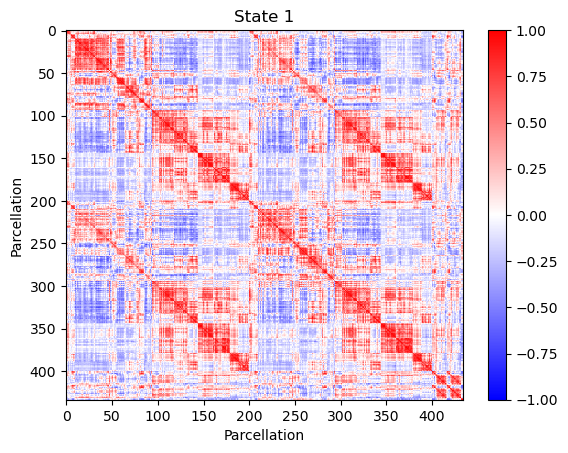

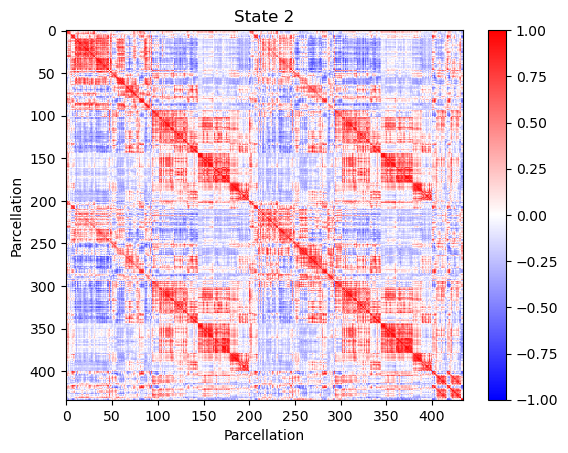

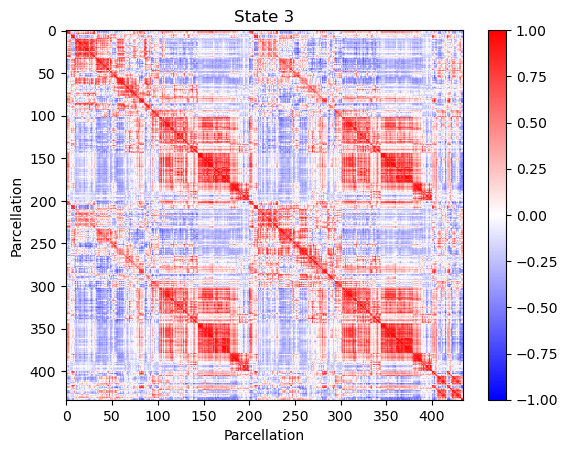

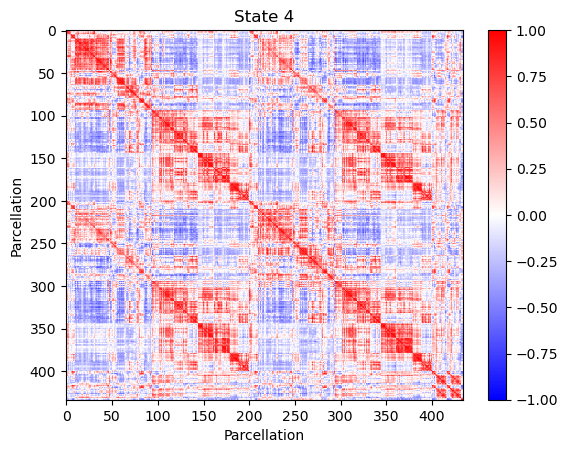

In [205]:
for k in range(n_states):
    plt.figure()
    plt.imshow(FC[k], aspect = 'auto', cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xlabel('Parcellation')
    plt.ylabel('Parcellation')
    plt.title('State '+str(k))
    plt.show()

In [185]:
fc_lyap_obs = fc_lyap_obs/(np.sqrt(np.outer(np.diag(fc_lyap_obs), np.diag(fc_lyap_obs))))

ValueError: shapes (434,15) and (5,15) not aligned: 15 (dim 1) != 5 (dim 0)

Text(0.5, 1.0, 'Functional connectivity matrix of state4')

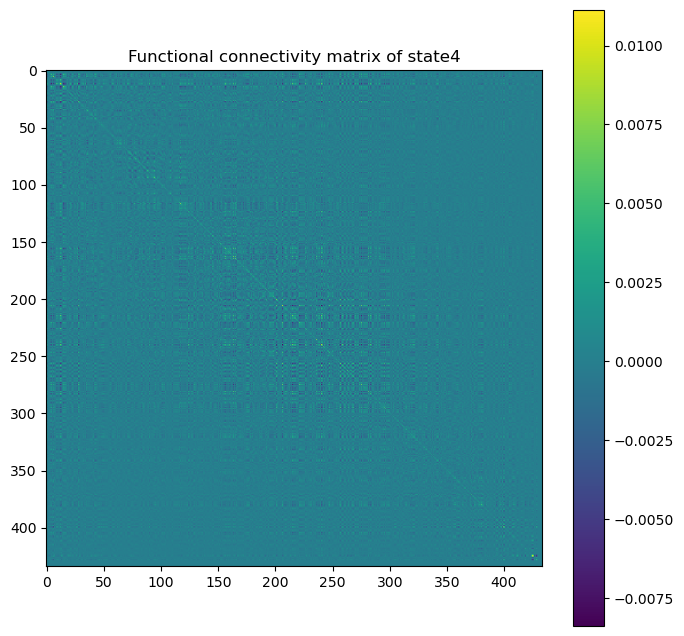

In [156]:
k = 4
U = eigenvectors[:, :n_components]
U = np.array(U)
Ut = np.transpose(U)


FC = U@covs[k]@Ut/np.trace(U@covs[k]@Ut)

plt.figure(figsize=(8, 8))
plt.imshow(FC)
plt.colorbar()
plt.title('Functional connectivity matrix of state'+str(k))

In [140]:
U.shape

(434, 15)

In [117]:
post_probs = post.predicted_probs

print(post_probs.shape)

occupied_state = np.argmax(post_probs, axis = 1)
occupied_state.shape

(107967, 4)


In [118]:
occupied_state = np.argmax(post_probs, axis = 1)
occupied_state.shape

(107967,)

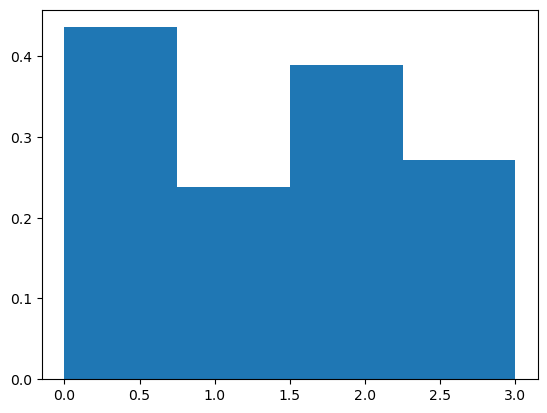

In [131]:
from itertools import groupby

def find_runs(arr):
    runs = []
    start = 0
    for value, group in groupby(arr):
        length = len(list(group))
        end = start + length
        runs.append((value, end-start))  # (valore, inizio, fine)
        start = end
    return runs

arr = [2, 2, 3, 3, 3, 1, 1, 2, 2, 2, 2]
runs = find_runs(occupied_state)

Array(1, dtype=int32)

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot your data on subplots

# Add colorbars to subplots
cbar1 = fig.colorbar(im1, ax=axs[0, 0])
cbar2 = fig.colorbar(im2, ax=axs[0, 1])
cbar3 = fig.colorbar(im3, ax=axs[1, 0])
cbar4 = fig.colorbar(im4, ax=axs[1, 1])

# Show the plot
plt.show()


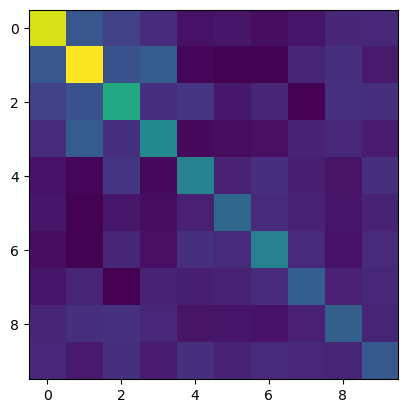

In [46]:
plt.imshow(covs[0])

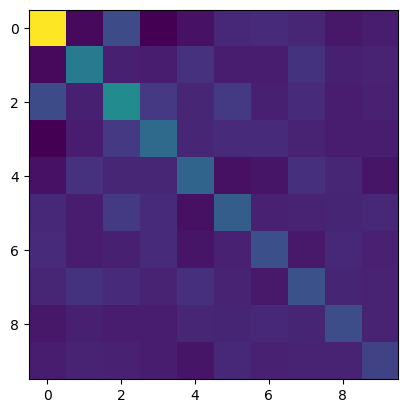

In [47]:
plt.imshow(covs[1])

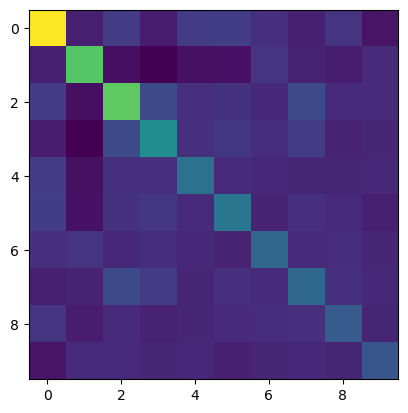

In [49]:
plt.imshow(covs[2])

In [ ]:
plt.imshow(covs[3])

In [440]:
# Initialize PCA
pca = PCA(n_components=n_components)

# Fit and transform the signal
projections = pca.fit_transform(x)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# eigenvectors
eigenvectors = pca.components_

In [441]:
### Transform states from pc to original space
means = params.emissions.means
covs = params.emissions.covs

print(means.shape, covs.shape)

means_orig = pca.inverse_transform(params.emissions.means)
cov_orig = np.stack( [pca.components_.T @ tmp_cov @ pca.components_ for tmp_cov in covs] )
print(means_orig.shape, cov_orig.shape)

#np.save(folder_results+f'mean_n_{num_states}_comp_{n_components}.npy', means_orig)
#np.save(folder_results+f'cov_n_{num_states}_comp_{n_components}.npy', cov_orig)

(4, 10) (4, 10, 10)


(4, 48800) (4, 48800, 48800)


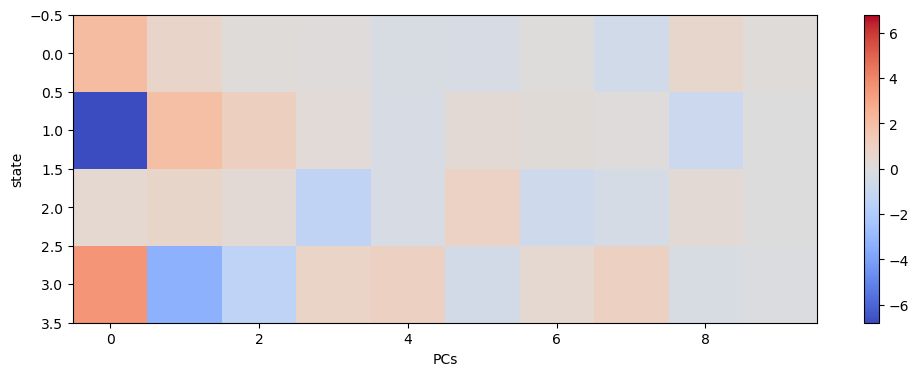

In [443]:
vmax = np.abs(means).max()
vmin = -vmax
plt.figure(figsize=(12,4))
plt.imshow(means, aspect='auto', vmin=vmin, vmax=vmax, cmap='coolwarm')
plt.colorbar()
plt.ylabel('state')
plt.xlabel('PCs')
plt.show()

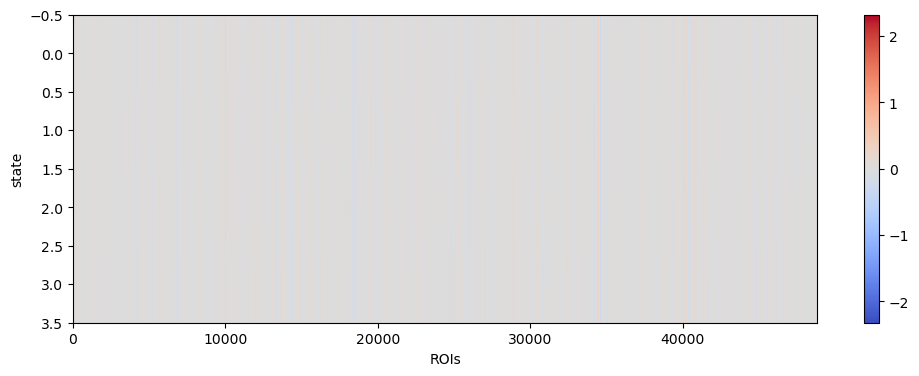

In [444]:
vmax = np.abs(means_orig).max()
vmin = -vmax
plt.figure(figsize=(12,4))
plt.imshow(means_orig, aspect='auto', vmin=vmin, vmax=vmax, cmap='coolwarm')
plt.colorbar()
plt.ylabel('state')
plt.xlabel('ROIs')
plt.show()